# Linear Factor Models Performance Measurement

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings(action = 'ignore')

In [3]:
industry_portfolios = pd.read_excel('Industry_Portfolios.xlsx')
market_portfolio = pd.read_excel('Market_Portfolio.xlsx')
risk_factors = pd.read_excel('Risk_Factors.xlsx')

In [4]:
risk_factors.head(2)

,Date,Rf,Rm-Rf,SMB,HML
0,200401,0.07,2.15,2.67,1.55
1,200402,0.06,1.40,-1.17,0.45


## Sharp Ratio
  <br>   Measure porfolio's risk premium per unit of its standard deviation, and it's appropriate for diversified portfolios with normally distributed returns but not useful for comparing individual investment and diversified portfolio since it include both systematic and idiosyncratic risk. A risk-averse investor is more willing to invest in a portfolio with higher Sharp Ratio.

In [5]:
Si = []

for portfolio in industry_portfolios.columns[1:]:
    expected_excess_return = np.mean(industry_portfolios[portfolio] - risk_factors['Rf'])
    std_dev = np.sqrt(np.var(industry_portfolios[portfolio] - risk_factors.Rf))
    Si.append(expected_excess_return/std_dev)
    
Performance_Metric = pd.DataFrame(Si, index = industry_portfolios.columns[1:], columns = ['Sharp_Ratio'])

## Sortino Ratio
   <br>  Measure expected deviation from target return per unit of below-target semi-deviation (downside risk), and is more infromative than Sharp ratio especially when dealing with asymetric or non-normal distrbution returns. A risk-averse investor will be more interested in in a portfolio with higher Sortino Ratio.

In [6]:
St = []
downside_return = industry_portfolios.copy()
    
for portfolio in industry_portfolios.columns[1:]:
    
    #Generate a table for downside_return that maintain negative excess return and set positive excess return equals to 0
    downside_return[portfolio] = industry_portfolios[portfolio] - risk_factors['Rf']
    downside_return[portfolio] = downside_return[portfolio].apply(lambda x: 0 if x > 0 else x)
    
    #Calculate Sortino Ratio
    T = len(industry_portfolios.index)
    St.append(np.mean(industry_portfolios[portfolio] - risk_factors['Rf']) 
                  /np.sqrt((1/T * np.sum(downside_return[portfolio]**2))))

Performance_Metric['Sortino_Ratio'] = St

## Treynor Ratio
  <br>   Measure risk premium per unit market risk. it's useful to compare performance of individual investment to diversified portfolio, because it ignores idiosyncratic risk and includes only systematic risk. A risk-averse investor is more willing to invest in a portfolio with higher Treynor Ratio.

In [7]:
beta = []

# Function for regression and return slope coefficient
def linear_regression(independent_variable):
    x = sm.add_constant(risk_factors['Rm-Rf'])
    MODEL = sm.OLS(industry_portfolios[independent_variable] - risk_factors['Rf'], x).fit()
    beta.append(MODEL.params[1])
    return beta

#Run OLS regression and generate a list of beta
for portfolio in industry_portfolios.columns[1:]:
    linear_regression(portfolio)
    
beta = pd.DataFrame(beta, index = industry_portfolios.columns[1:], columns = ['beta']).T

#Calculate Treynor Ratio
Treynor_Ratio = []
for portfolio in industry_portfolios.columns[1:]:
    expected_excess_return = np.mean(industry_portfolios[portfolio] - risk_factors['Rf'])
    Treynor_Ratio.append(expected_excess_return / beta[portfolio][0])

Performance_Metric['Treynor Ratio'] = Treynor_Ratio

## Jensen's Alpha
   <br>  It's the intercept coefficient derived from regression of CAPM. It can be interpreted as pricing error for passive portfolio while as abnormal mean return for exposure to market risk for active portfolio. A passive portfolio manager is seeking zero Jenen's Alpha, while an active portfolio manager is trying to get a Jenen's Alpha above zero, which means outperforming the market.

In [8]:
alpha = []

for portfolio in industry_portfolios.columns[1:]:
    expected_excess_return = np.mean(industry_portfolios[portfolio] - risk_factors['Rf'])
    market_expected_excess_return = np.mean(risk_factors['Rm-Rf'])
    alpha.append(expected_excess_return - beta[portfolio][0]*market_expected_excess_return)

Performance_Metric['Jensen\'s Alpha'] = alpha

## Three-Factor Alpha
   <br>  It's the intercept coefficient derived from regression of Fama-French three-factor model, interpreted as pricing error that cannot explained by the model and expected to be zero.

In [9]:
three_factor_alpha = []

# Function for regression and return slope coefficient
def linear_regression(independent_variable):
    x = sm.add_constant(risk_factors[['Rm-Rf', 'SMB', 'HML']])
    MODEL = sm.OLS(industry_portfolios[independent_variable] - risk_factors['Rf'], x).fit()
    three_factor_alpha.append(MODEL.params[0])
    return three_factor_alpha

#Run OLS regression and generate a list of beta
for portfolio in industry_portfolios.columns[1:]:
    linear_regression(portfolio)
    
Performance_Metric['Three-Factor Alpha'] = three_factor_alpha

## Performance Metric

In [10]:
Performance_Metric

,Sharp_Ratio,Sortino_Ratio,Treynor Ratio,Jensen's Alpha,Three-Factor Alpha
NoDur,0.232068,0.350804,1.186372,0.369717,0.386704
Durbl,0.072659,0.111967,0.367463,-0.417903,-0.474342
Manuf,0.167315,0.241260,0.758251,0.160494,0.153285
Enrgy,0.182470,0.273612,1.143330,0.504485,0.523007
HiTec,0.119050,0.170620,0.564295,-0.064024,-0.065979
Telcm,0.169773,0.244940,0.836363,0.194348,0.200724
Shops,0.192557,0.293032,0.951258,0.274093,0.255941
Hlth,0.173253,0.270294,0.971435,0.236968,0.257472
Utils,0.211832,0.290044,1.452334,0.446523,0.474411
Other,0.064964,0.087351,0.299781,-0.387508,-0.404412


## Visualization

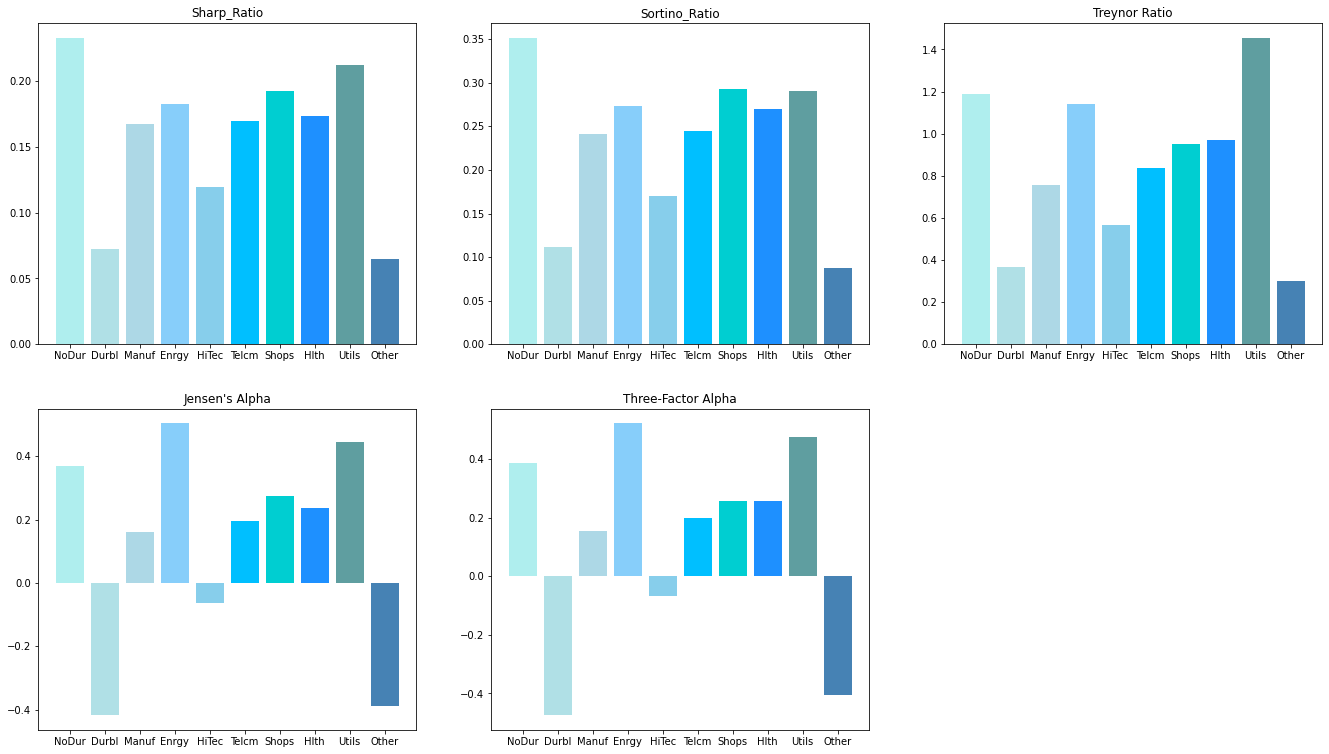

In [11]:
fig = plt.figure(figsize = (23, 13))
for i in range(0, 5):
    ax = fig.add_subplot(2,3,int(i+1))
    ax.bar(Performance_Metric.index, Performance_Metric.iloc[:, i], 
              color = ['paleturquoise', 'powderblue', 'lightblue', 'lightskyblue', 'skyblue', 
                         'deepskyblue',  'darkturquoise', 'dodgerblue', 'cadetblue', 'steelblue'])
    plt.title(Performance_Metric.columns[i])
plt.show()